In [6]:
import numpy as np
import uproot
import vector
import awkward as ak
import matplotlib.pyplot as plt
import mplhep as hep
import pandas as pd
import sklearn as skl
import torch 
seed_value = 420 
from numpy.random import seed
seed(seed_value)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as Data
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import roc_curve
import itertools
from sklearn.inspection import permutation_importance
import boost_histogram as bh
import itertools

#directory = "/Users/archiebrooks/Documents/Uni/mphys project/"
directory = "c:/Users/matis/OneDrive/Documents/Y4/Project/"

hep.style.use('ATLAS')

   ### Functions for plotting

In [7]:
def histogram(data, bins, data_label, axes, density=False, ratio=False, ratio_axes=None, set_range = None, weight_array=None, x_units='GeV'):
    if len(data[0]) != 1:
        if set_range is not None:
            global_min, global_max = set_range
        else:
            global_min = min([np.min(d) for d in data])
            global_max = max([np.max(d) for d in data])

        bin_edges = np.linspace(global_min, global_max, bins+1)
        counts = []
        errors = []
        bin_width = bin_edges[1]-bin_edges[0]
        for i in range(len(data)):
            if type(data[i])!= 'numpy.ndarray':
                data[i] = np.array(ak.to_numpy(data[i]))
            hist = bh.Histogram(bh.axis.Regular(bins, global_min, global_max))
            hist.fill(data[i], weight=weight_array[i]) if weight_array is not None else hist.fill(data[i])
            norm_factor = np.sum(hist.counts() * np.diff(hist.axes[0].edges))
            if density: hep.histplot(hist.counts()/norm_factor, hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances())/norm_factor,label=data_label[i], histtype='step')
            else: hep.histplot(hist.counts(), hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances()),label=data_label[i], histtype='step')
            counts.append(hist.counts()/norm_factor) if density else counts.append(hist.counts())
            errors.append(np.sqrt(hist.variances())/norm_factor) if density else errors.append(np.sqrt(hist.variances()))       
    else:
        hist = bh.Histogram(bh.axis.Regular(bins, global_min, global_max))
        hist.fill(data[i])
        hep.histplot(hist.view(), hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances()), label=data_label, histtype='step')

    bin_width = hist.axes[0].edges[1]-hist.axes[0].edges[0]
    axes.set_ylabel(f'Events /{bin_width:.2g} {x_units}')
    axes.legend()

    if ratio:
        reference_counts = counts[0]
        for i in range(1, len(counts)):
            ratio_values = np.divide(counts[i], reference_counts, out=np.zeros_like(counts[i]), where=reference_counts != 0)
            ratio_errors = np.sqrt(np.divide(errors[i],counts[i], out=np.zeros_like(counts[i]), where=counts[i]!=0)**2 + (np.divide(errors[0],counts[0], out=np.zeros_like(counts[0]), where=counts[0]!=0)**2))
            hep.histplot(ratio_values, bin_edges, ax=ratio_axes, yerr=ratio_errors, label=f'{data_label[i]}/{data_label[0]}')
        ratio_axes.set_ylabel("Ratio")
        ratio_axes.set_xlabel(axes.get_xlabel())
        ratio_axes.axhline(1, color='black', linestyle='--')  # Reference line at ratio=1
        ratio_axes.legend()
        if ratio_axes.get_ylim()[1]>5:
            ratio_axes.set_ylim(0,5)

    hep.atlas.label(ax=axes)

def n_combinations(particles, n, dictionary, type):
    i = n
    while len(particles[ak.num(particles)>=i])!=0:
        particles_i = particles[ak.num(particles)==i]
        if len(particles_i)==0:
            i+=1
            continue
        indices = np.array(list(itertools.combinations(range(np.shape(particles_i)[1]), n)))
        dictionary[type+f'_{i}'] = particles_i[:, indices]
        i += 1
    return None

def truth_matching(reco, truth):
    id = np.tile(np.arange(1,len(truth[0])+1), (len(truth),1))
    pairs_2d = ak.cartesian({'reco':reco,'truth':truth})
    id_pairs_2d = ak.cartesian({'reco':reco,'id':id})
    pairs_3d = ak.unflatten(pairs_2d, len(truth[0]), axis=1)
    id_pairs_3d = ak.unflatten(id_pairs_2d, len(truth[0]), axis=1)

    deltars = pairs_3d['reco'].deltaR(pairs_3d['truth'])
    min_deltars = np.min(deltars, axis=2)
    id_pairs_3d = id_pairs_3d[(deltars == min_deltars)]
    id_pairs_3d = id_pairs_3d[min_deltars<0.4]

    return id_pairs_3d

mass_lookup = {
    1: 2.16E-3,
    2: 4.7E-3,
    3: 1.273,
    4: 93.5E-3,
    5: 172.57,
    6: 4.183,
    11: 0.511E-3,
    12: 0,
    13: 105.66E-3,
    14: 0,
    15: 1.77693,
    16: 0,
    21: 0
}

### Combinations

## Extracting Data

### Partonic

In [8]:
tree4 = uproot.open(directory + '4tops_partonic_skimmed_2409.root')['tree']
events4 = tree4.arrays(['top_pt', 'top_eta', 'top_phi', 'top_e', 'anti_top_pt', 'anti_top_eta', 'anti_top_phi', 'anti_top_e'])

tops_pt_4t = ak.concatenate((events4['top_pt'], events4['anti_top_pt']), axis=1)
tops_e_4t = ak.concatenate((events4['top_e'], events4['anti_top_e']), axis=1)
tops_eta_4t = ak.concatenate((events4['top_eta'], events4['anti_top_eta']), axis=1)
tops_phi_4t = ak.concatenate((events4['top_phi'], events4['anti_top_phi']), axis=1)

tree3W = uproot.open(directory + '3tops_tttW_partonic_skimmed_2609.root')['tree']
events3W = tree3W.arrays(['top_pt', 'top_eta', 'top_phi', 'top_e', 'anti_top_pt', 'anti_top_eta', 'anti_top_phi', 'anti_top_e'])

tops_pt_3W = ak.concatenate([events3W['top_pt'],events3W['anti_top_pt']], axis=1)
tops_eta_3W = ak.concatenate([events3W['top_eta'],events3W['anti_top_eta']], axis=1)
tops_phi_3W = ak.concatenate([events3W['top_phi'],events3W['anti_top_phi']], axis=1)
tops_e_3W = ak.concatenate([events3W['top_e'],events3W['anti_top_e']], axis=1)

tree3j = uproot.open(directory + '3tops_tttW_partonic_skimmed_2609.root')['tree']
events3j = tree3j.arrays(['top_pt', 'top_eta', 'top_phi', 'top_e', 'anti_top_pt', 'anti_top_eta', 'anti_top_phi', 'anti_top_e'])

tops_pt_3j = ak.concatenate([events3j['top_pt'],events3j['anti_top_pt']], axis=1)
tops_eta_3j = ak.concatenate([events3j['top_eta'],events3j['anti_top_eta']], axis=1)
tops_phi_3j = ak.concatenate([events3j['top_phi'],events3j['anti_top_phi']], axis=1)
tops_e_3j = ak.concatenate([events3j['top_e'],events3j['anti_top_e']], axis=1)

tops_pt_3 = ak.concatenate([tops_pt_3W,tops_pt_3j], axis=0)
tops_eta_3 = ak.concatenate([tops_eta_3W,tops_eta_3j], axis=0)
tops_phi_3 = ak.concatenate([tops_phi_3W,tops_phi_3j], axis=0)
tops_e_3 = ak.concatenate([tops_e_3W,tops_e_3j], axis=0)

In [9]:
tree3W = uproot.open(directory + '3tops_tttW_partonic_skimmed_2609.root')['tree']
events3W = tree3W.arrays(['top_pt', 'top_eta', 'top_phi', 'top_e', 'anti_top_pt', 'anti_top_eta', 'anti_top_phi', 'anti_top_e'])

events3W['pt'] = ak.concatenate([events3W['top_pt'],events3W['anti_top_pt']], axis=1)
events3W['eta'] = ak.concatenate([events3W['top_eta'],events3W['anti_top_eta']], axis=1)
events3W['phi'] = ak.concatenate([events3W['top_phi'],events3W['anti_top_phi']], axis=1)
events3W['e'] = ak.concatenate([events3W['top_e'],events3W['anti_top_e']], axis=1)

mask_tttbarW = (ak.num(events3W['top_pt']) == 2) & (ak.num(events3W['anti_top_pt']) == 1)
mask_ttbartbarW = (ak.num(events3W['top_pt']) == 1) & (ak.num(events3W['anti_top_pt']) == 2)
tttbarW = events3W[mask_tttbarW]
ttbartbarW = events3W[mask_ttbartbarW]

tree3j = uproot.open(directory + '3tops_tttj_partonic_skimmed_2609.root')['tree']
events3j = tree3j.arrays(['top_pt', 'top_eta', 'top_phi', 'top_e', 'anti_top_pt', 'anti_top_eta', 'anti_top_phi', 'anti_top_e'])

events3j['pt'] = ak.concatenate([events3j['top_pt'],events3j['anti_top_pt']], axis=1)
events3j['eta'] = ak.concatenate([events3j['top_eta'],events3j['anti_top_eta']], axis=1)
events3j['phi'] = ak.concatenate([events3j['top_phi'],events3j['anti_top_phi']], axis=1)
events3j['e'] = ak.concatenate([events3j['top_e'],events3j['anti_top_e']], axis=1)

In [10]:
tops = vector.zip({'pt':events4['top_pt'],'eta':events4['top_eta'],'phi':events4['top_phi'], 'mass':172.76})
anti_tops = vector.zip({'pt':events4['anti_top_pt'],'eta':events4['anti_top_eta'],'phi':events4['anti_top_phi'], 'mass':172.76})

top1 = vector.zip({'pt':events4['top_pt'][:,0],'eta':events4['top_eta'][:,0],'phi':events4['top_phi'][:,0], 'mass':172.76})
top2 = vector.zip({'pt':events4['top_pt'][:,1],'eta':events4['top_eta'][:,1],'phi':events4['top_phi'][:,1], 'mass':172.76})
anti_top1 = vector.zip({'pt':events4['anti_top_pt'][:,0],'eta':events4['anti_top_eta'][:,0],'phi':events4['anti_top_phi'][:,0], 'mass':172.76})
anti_top2 = vector.zip({'pt':events4['anti_top_pt'][:,1],'eta':events4['anti_top_eta'][:,1],'phi':events4['anti_top_phi'][:,1], 'mass':172.76})

all_4tops = ak.concatenate([ak.Array([top1]),ak.Array([top2]),ak.Array([anti_top1]),ak.Array([anti_top2])], axis=0)

four_tops = top1+top2+anti_top1+anti_top2

In [11]:
top1_3tW = vector.zip({'pt':events3W['pt'][:,0],'eta':events3W['eta'][:,0],'phi':events3W['phi'][:,0], 'mass':172.76})
top2_3tW = vector.zip({'pt':events3W['pt'][:,1],'eta':events3W['eta'][:,1],'phi':events3W['phi'][:,1], 'mass':172.76})
top3_3tW = vector.zip({'pt':events3W['pt'][:,2],'eta':events3W['eta'][:,2],'phi':events3W['phi'][:,2], 'mass':172.76})

all_3tW = ak.concatenate([ak.Array([top1_3tW]),ak.Array([top2_3tW]),ak.Array([top3_3tW])],axis=0)

top1_3tj = vector.zip({'pt':events3j['pt'][:,0],'eta':events3j['eta'][:,0],'phi':events3j['phi'][:,0], 'mass':172.76})
top2_3tj = vector.zip({'pt':events3j['pt'][:,1],'eta':events3j['eta'][:,1],'phi':events3j['phi'][:,1], 'mass':172.76})
top3_3tj = vector.zip({'pt':events3j['pt'][:,2],'eta':events3j['eta'][:,2],'phi':events3j['phi'][:,2], 'mass':172.76})

all_3tj = ak.concatenate([ak.Array([top1_3tj]),ak.Array([top2_3tj]),ak.Array([top3_3tj])],axis=0)

In [12]:
combined_3t = ak.concatenate([ak.Array(all_3tj),ak.Array(all_3tW)], axis = 1)
transposed_3t = np.transpose(combined_3t)

transposed_4t = np.transpose(all_4tops)

In [13]:
tops_4t = vector.zip({'pt':tops_pt_4t,'eta':tops_eta_4t,'phi':tops_phi_4t, 'e':tops_e_4t})
tops_3t = vector.zip({'pt':tops_pt_3,'eta':tops_eta_3,'phi':tops_phi_3, 'mass':tops_e_3})

In [14]:
#pt
sorted_indices = np.argsort(transposed_4t.rho)
trans_sorted_4t = transposed_4t[sorted_indices]

highest_pt_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':172.76})
second_highest_pt_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':172.76})
third_highest_pt_4t = vector.zip({'pt':trans_sorted_4t.rho[:,1],'eta':trans_sorted_4t.eta[:,1],'phi':trans_sorted_4t.phi[:,1], 'mass':172.76})
lowest_pt_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(transposed_3t.rho)
trans_sorted_3t = transposed_3t[sorted_indices]

highest_pt_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':172.76})
middle_pt_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':172.76})
lowest_pt_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':172.76})

#eta
sorted_indices = np.argsort(transposed_4t.eta)
trans_sorted_4t = transposed_4t[sorted_indices]

highest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':172.76})
second_highest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':172.76})
third_highest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,1],'eta':trans_sorted_4t.eta[:,1],'phi':trans_sorted_4t.phi[:,1], 'mass':172.76})
lowest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(transposed_3t.eta)
trans_sorted_3t = transposed_3t[sorted_indices]

highest_eta_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':172.76})
middle_eta_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':172.76})
lowest_eta_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(np.abs(transposed_4t.eta))
trans_sorted_4t = transposed_4t[sorted_indices]

abs_highest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':172.76})
abs_second_highest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':172.76})
abs_third_highest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,1],'eta':trans_sorted_4t.eta[:,1],'phi':trans_sorted_4t.phi[:,1], 'mass':172.76})
abs_lowest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(np.abs(transposed_3t.eta))
trans_sorted_3t = transposed_3t[sorted_indices]

abs_highest_eta_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':172.76})
abs_middle_eta_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':172.76})
abs_lowest_eta_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':172.76})

#phi
sorted_indices = np.argsort(transposed_4t.phi)
trans_sorted_4t = transposed_4t[sorted_indices]

highest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':172.76})
second_highest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':172.76})
third_highest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,1],'eta':trans_sorted_4t.eta[:,1],'phi':trans_sorted_4t.phi[:,1], 'mass':172.76})
lowest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(transposed_3t.phi)
trans_sorted_3t = transposed_3t[sorted_indices]

highest_phi_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':172.76})
middle_phi_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':172.76})
lowest_phi_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(np.abs(transposed_4t.phi))
trans_sorted_4t = transposed_4t[sorted_indices]

abs_highest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':172.76})
abs_second_highest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':172.76})
abs_third_highest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,1],'eta':trans_sorted_4t.eta[:,1],'phi':trans_sorted_4t.phi[:,1], 'mass':172.76})
abs_lowest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(np.abs(transposed_3t.phi))
trans_sorted_3t = transposed_3t[sorted_indices]

abs_highest_phi_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':172.76})
abs_middle_phi_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':172.76})
abs_lowest_phi_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':172.76})

#Energy
sorted_indices = np.argsort(np.sqrt((transposed_4t.rho**2)*(np.cosh(transposed_4t.eta)**2) + transposed_4t.tau**2))
trans_sorted_4t = transposed_4t[sorted_indices]

highest_e_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':172.76})
second_highest_e_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':172.76})
third_highest_e_4t = vector.zip({'pt':trans_sorted_4t.rho[:,1],'eta':trans_sorted_4t.eta[:,1],'phi':trans_sorted_4t.phi[:,1], 'mass':172.76})
lowest_e_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(np.sqrt((transposed_3t.rho**2)*(np.cosh(transposed_3t.eta)**2) + transposed_3t.tau**2))
trans_sorted_3t = transposed_3t[sorted_indices]

highest_e_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':172.76})
middle_e_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':172.76})
lowest_e_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':172.76})

## Machine learning

### Data conversions

In [15]:
duos_4t = ak.combinations(tops_4t, 2, axis=1)
duos_3t = ak.combinations(tops_3t, 2, axis=1)

duo_masses_4t = np.mean((duos_4t["0"]+duos_4t["1"]).m, axis=1)
deltaphi_4t = np.mean(duos_4t["0"].deltaphi(duos_4t["1"]), axis=1)
deltaR_4t = np.mean(duos_4t["0"].deltaR(duos_4t["1"]), axis=1)
deltaeta_4t = np.mean(np.abs(duos_4t["0"].deltaeta(duos_4t["1"])), axis=1)
deltapt_4t = np.mean((duos_4t["0"].pt - (duos_4t["1"]).pt), axis=1)

duo_masses_3t = np.mean((duos_3t["0"]+duos_3t["1"]).m, axis=1)
deltaphi_3t = np.mean(duos_3t["0"].deltaphi(duos_3t["1"]), axis=1)
deltaR_3t = np.mean(duos_3t["0"].deltaR(duos_3t["1"]), axis=1)
deltaeta_3t = np.mean(np.abs(duos_3t["0"].deltaeta(duos_3t["1"])), axis=1)
deltapt_3t = np.mean((duos_3t["0"].pt - (duos_3t["1"]).pt), axis=1)

In [16]:
#deltaR
pt_deltaR_4t = highest_pt_4t.deltaR(second_highest_pt_4t)
eta_deltaR_4t = highest_eta_4t.deltaR(second_highest_eta_4t)
abs_eta_deltaR_4t = abs_highest_eta_4t.deltaR(abs_second_highest_eta_4t)
phi_deltaR_4t = lowest_phi_4t.deltaR(third_highest_phi_4t)
abs_phi_deltaR_4t = abs_highest_phi_4t.deltaR(abs_second_highest_phi_4t)
e_deltaR_4t = highest_e_4t.deltaR(second_highest_e_4t)

pt_deltaR_3t = highest_pt_3t.deltaR(middle_pt_3t)
eta_deltaR_3t = highest_eta_3t.deltaR(middle_eta_3t)
abs_eta_deltaR_3t = abs_highest_eta_3t.deltaR(abs_middle_eta_3t)
phi_deltaR_3t = lowest_phi_3t.deltaR(middle_phi_3t)
abs_phi_deltaR_3t = abs_highest_phi_3t.deltaR(abs_middle_phi_3t)
e_deltaR_3t = highest_e_3t.deltaR(middle_e_3t)

#deltaphi
high_delta_phi_4t = np.abs(highest_phi_4t.deltaphi(second_highest_phi_4t))
high_delta_eta_4t = np.abs(highest_phi_4t.deltaeta(second_highest_phi_4t))
low_delta_phi_4t = np.abs(third_highest_phi_4t.deltaphi(lowest_phi_4t))
low_delta_eta_4t = np.abs(third_highest_phi_4t.deltaeta(lowest_phi_4t))

high_delta_phi_3t = np.abs(highest_phi_3t.deltaphi(middle_phi_3t))
high_delta_eta_3t = np.abs(highest_phi_3t.deltaeta(middle_phi_3t))
low_delta_phi_3t = np.abs(middle_phi_3t.deltaphi(lowest_phi_3t))
low_delta_eta_3t = np.abs(middle_phi_3t.deltaeta(lowest_phi_3t))

#centrality
def centrality(particle, reference_1, reference_2):
    return np.abs(particle.rapidity - 0.5*(reference_1.rapidity + reference_2.rapidity))/np.abs(reference_1.rapidity-reference_2.rapidity)

centrality_1_3t = centrality(highest_pt_3t, middle_pt_3t, lowest_pt_3t)
centrality_2_3t = centrality(middle_pt_3t, highest_pt_3t, lowest_pt_3t)
centrality_3_3t = centrality(lowest_pt_3t, highest_pt_3t, middle_pt_3t)

centrality_1_4t = centrality(highest_pt_4t, second_highest_pt_4t, third_highest_pt_4t)
centrality_2_4t = centrality(second_highest_pt_4t, highest_pt_4t, third_highest_pt_4t)
centrality_3_4t = centrality(third_highest_pt_4t, highest_pt_4t, second_highest_pt_4t)

#Transverse Sphericity
sum_pt_3t = np.sum(tops_3t.pt, axis=1)
S_xy_3t = np.zeros((len(tops_3t),2,2))

S_xy_3t[:,0,0] = np.sum(tops_3t.px**2/ tops_3t.pt, axis=1)
S_xy_3t[:,0,1] = np.sum((tops_3t.px*tops_3t.py)/ tops_3t.pt, axis=1)
S_xy_3t[:,1,0] = S_xy_3t[:,0,1]
S_xy_3t[:,1,1] = np.sum(tops_3t.py**2/ tops_3t.pt, axis=1)

S_xy_3t = S_xy_3t/sum_pt_3t[:,np.newaxis,np.newaxis]

transverse_eigenvalues_3t = np.linalg.eigvalsh(S_xy_3t)
transverse_sphericity_3t = 2*np.min(transverse_eigenvalues_3t, axis=1)/np.sum(transverse_eigenvalues_3t, axis=1)

sum_pt_4t = np.sum(tops_4t.pt, axis=1)
S_xy_4t = np.zeros((len(tops_4t),2,2))

S_xy_4t[:,0,0] = np.sum(tops_4t.px**2/ tops_4t.pt, axis=1)
S_xy_4t[:,0,1] = np.sum((tops_4t.px*tops_4t.py)/ tops_4t.pt, axis=1)
S_xy_4t[:,1,0] = S_xy_4t[:,0,1]
S_xy_4t[:,1,1] = np.sum(tops_4t.py**2/ tops_4t.pt, axis=1)

S_xy_4t = S_xy_4t/sum_pt_4t[:,np.newaxis,np.newaxis]

transverse_eigenvalues_4t = np.linalg.eigvalsh(S_xy_4t)
transverse_sphericity_4t = 2*np.min(transverse_eigenvalues_4t, axis=1)/np.sum(transverse_eigenvalues_4t, axis=1)

#Spericity
sum_p_3t = np.sum(tops_3t.p, axis=1)
S_xyz_3t = np.zeros((len(tops_3t),3,3))

S_xyz_3t[:,0,0] = np.sum(tops_3t.px**2/ tops_3t.p, axis=1)
S_xyz_3t[:,0,1] = np.sum((tops_3t.px*tops_3t.py)/ tops_3t.p, axis=1)
S_xyz_3t[:,0,2] = np.sum((tops_3t.px*tops_3t.pz)/ tops_3t.p, axis=1)
S_xyz_3t[:,1,2] = np.sum((tops_3t.py*tops_3t.pz)/ tops_3t.p, axis=1)
S_xyz_3t[:,1,0] = S_xyz_3t[:,0,1]
S_xyz_3t[:,2,0] = S_xyz_3t[:,0,2]
S_xyz_3t[:,2,1] = S_xyz_3t[:,1,2]
S_xyz_3t[:,1,1] = np.sum(tops_3t.py**2/ tops_3t.p, axis=1)
S_xyz_3t[:,2,2] = np.sum(tops_3t.pz**2/ tops_3t.p, axis=1)

S_xyz_3t = S_xyz_3t/sum_p_3t[:,np.newaxis,np.newaxis]

eigenvalues_3t = np.linalg.eigvalsh(S_xyz_3t)
sphericity_3t = 2*np.min(eigenvalues_3t, axis=1)/np.sum(eigenvalues_3t, axis=1)

sum_p_4t = np.sum(tops_4t.p, axis=1)
S_xyz_4t = np.zeros((len(tops_4t),3,3))

S_xyz_4t[:,0,0] = np.sum(tops_4t.px**2/ tops_4t.p, axis=1)
S_xyz_4t[:,0,1] = np.sum((tops_4t.px*tops_4t.py)/ tops_4t.p, axis=1)
S_xyz_4t[:,0,2] = np.sum((tops_4t.px*tops_4t.pz)/ tops_4t.p, axis=1)
S_xyz_4t[:,1,2] = np.sum((tops_4t.py*tops_4t.pz)/ tops_4t.p, axis=1)
S_xyz_4t[:,1,0] = S_xyz_4t[:,0,1]
S_xyz_4t[:,2,0] = S_xyz_4t[:,0,2]
S_xyz_4t[:,2,1] = S_xyz_4t[:,1,2]
S_xyz_4t[:,1,1] = np.sum(tops_4t.py**2/ tops_4t.p, axis=1)
S_xyz_4t[:,2,2] = np.sum(tops_4t.pz**2/ tops_4t.p, axis=1)

S_xyz_4t = S_xyz_4t/sum_p_4t[:,np.newaxis,np.newaxis]

eigenvalues_4t = np.linalg.eigvalsh(S_xyz_4t)
sphericity_4t = 2*np.min(eigenvalues_4t, axis=1)/np.sum(eigenvalues_4t, axis=1)

In [17]:
tops_4t_total_4 = np.sum(tops_4t,axis=1)

tops_4t_H_t = np.sum(tops_4t.pt,axis=1)
tops_4t_invariant_mass = np.sum(tops_4t.m,axis=1)
tops_4t_sum_inv_mass = tops_4t_total_4.m
tops_4t_sphericity = sphericity_4t
tops_4t_sum_pt = tops_4t_total_4.pt
tops_4t_delta_R = pt_deltaR_4t

combined_data_4t_partonic = np.vstack(
    (highest_pt_4t.pt,
     lowest_pt_4t.pt,
     highest_eta_4t.eta,
     lowest_eta_4t.eta,
     highest_phi_4t.phi,
     lowest_phi_4t.phi,
     highest_e_4t.e,
     lowest_e_4t.e,
     tops_4t_H_t,
     tops_4t_invariant_mass,
     tops_4t_sum_inv_mass,
     tops_4t_sphericity,
     tops_4t_sum_pt,
     tops_4t_delta_R,
     deltapt_4t,
     deltaphi_4t,
     deltaR_4t,
     deltaeta_4t,
     ))

tops_3t_total_3 = np.sum(tops_3t,axis=1)

tops_3t_H_t = np.sum(tops_3t.pt,axis=1)
tops_3t_invariant_mass = np.sum(tops_3t.m,axis=1)
tops_3t_sum_inv_mass = tops_3t_total_3.m
tops_3t_sphericity = sphericity_3t
tops_3t_sum_pt = tops_3t_total_3.pt
tops_3t_delta_R = pt_deltaR_3t

combined_data_3t_partonic = np.vstack(
    (highest_pt_3t.pt,
     lowest_pt_3t.pt,
     highest_eta_3t.eta,
     lowest_eta_3t.eta,
     highest_phi_3t.phi,
     lowest_phi_3t.phi,
     highest_e_3t.e,
     lowest_e_3t.e,
     tops_3t_H_t,
     tops_3t_invariant_mass,
     tops_3t_sum_inv_mass,
     tops_3t_sphericity,
     tops_3t_sum_pt,
     tops_3t_delta_R,
     deltapt_3t,
     deltaphi_3t,
     deltaR_3t,
     deltaeta_3t,
     ))

In [18]:
combined_partonic_data = np.hstack((combined_data_4t_partonic,combined_data_3t_partonic))
trans_partonic_data = np.transpose(combined_partonic_data)
print(np.shape(trans_partonic_data))

[150000, 18]


In [19]:
n_signal_partonic = len(combined_data_4t_partonic[0])
n_background_partonic = len(combined_data_3t_partonic[0])
labels_partonic = np.concatenate((np.ones(n_signal_partonic),np.zeros(n_background_partonic)))

### Features:


In [20]:
partonic_names = [
    (r'Highest $p_T$'),
    (r'Lowest $p_T$'),
    (r'Highest $\eta$'),
    (r'Lowest $\eta$'),
    (r'Highest $\phi$'),
    (r'Lowest $\phi$'),
    (r'Highest energy'),
    (r'Lowest energy'),
    (r'$H_T$'),
    (r'Invariant Mass'),
    (r'$\Sigma$ individual invariant masses'),
    (r'Sphericity'),
    (r'$\Sigma$ $p_T$'),
    (r'$\Delta$R'),
    (r'$\overline{\Delta p_T}$'),
    (r'$\overline{\Delta \phi}$'),
    (r'$\overline{\Delta R}$'),
    (r'$|\overline{\Delta\eta}|$'),
]

In [21]:
features_deleted = []
print(np.shape(combined_partonic_data))
print(len(partonic_names))
combined_partonic_data_reduced = np.delete(combined_partonic_data,features_deleted,axis = 0)
print(np.shape(combined_partonic_data_reduced))
trans_partonic_data_reduced = np.transpose(combined_partonic_data_reduced)

feature_names_reduced = np.delete(partonic_names,features_deleted,axis=0)
print(len(feature_names_reduced))

[18, 150000]
18
[18, 150000]
18


In [24]:
X = trans_partonic_data_reduced
y = labels_partonic

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed_value)

In [26]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.transform(X)

In [27]:
epochs = 20  # number of training epochs
batch_size = 64  # number of samples per batch
input_size = len(X[1])  # The number of features
num_classes = 2  # The number of output classes. In this case: [signal, background]
hidden_size = 64
hidden_size1 = 64  # The number of nodes at the first hidden layer
hidden_size2 = 64  # The number of nodes at the second hidden layer
dropout_rate = 0.2
learning_rate = 0.01  # The speed of convergence
verbose = True  # flag for printing out stats at each epoch
torch.manual_seed(seed_value)  # set random seed for PyTorch

In [28]:
X_train_tensor = torch.as_tensor(X_train_scaled, dtype=torch.float)  # make tensor from X_train_scaled
y_train_tensor = torch.as_tensor(y_train, dtype=torch.long)  # make tensor from y_train

X_train_var, y_train_var = Variable(X_train_tensor), Variable(y_train_tensor)  # make variables from tensors

X_valid_var, y_valid_var = (X_train_var[:100],y_train_var[:100],)  # get first 100 events for validation
X_train_nn_var, y_train_nn_var = (X_train_var[100:],y_train_var[100:],)  # get remaining events for training

train_data = Data.TensorDataset(X_train_nn_var, y_train_nn_var)  # create training dataset
valid_data = Data.TensorDataset(X_valid_var, y_valid_var)  # create validation dataset

train_loader = Data.DataLoader(dataset=train_data,batch_size=batch_size,shuffle=True,)
valid_loader = Data.DataLoader(dataset=valid_data,batch_size=batch_size,shuffle=True,)

In [29]:
for batch in train_loader:
    x_train_batch, y_train_batch = batch

In [30]:
class Classifier_MLP_full(nn.Module):
    def __init__(self, in_dim, hidden_dim1, hidden_dim2, dropout_rate, out_dim):
        super().__init__()
        self.h1 = nn.Linear(in_dim, hidden_dim1)
        self.h2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.h3 = nn.Dropout(dropout_rate)
        self.out = nn.Linear(hidden_dim2, out_dim)
        self.out_dim = out_dim        

    def forward(self, x):
        x = F.relu(self.h1(x))
        x = F.relu(self.h2(x))
        x = F.relu(self.h3(x))
        x = self.out(x)
        return x, F.softmax(x,dim=1)

    def fit(self, train_loader, valid_loader, verbose=True):
        _results = []  # Store training and validation metrics
        for epoch in range(epochs):
            # Training loop
            self.train()  # Set the model to training mode
            with torch.enable_grad():
                train_loss = 0.0
                for batch, (x_train_batch, y_train_batch) in enumerate(train_loader):
                    self.zero_grad()  # Zero gradients
                    out, prob = self(x_train_batch)  # Forward pass
                    loss = F.cross_entropy(out, y_train_batch)  # Compute loss
                    loss.backward()  # Backpropagation
                    optimizer.step()  # Update weights
                    train_loss += loss.item() * x_train_batch.size(0)

            train_loss /= len(train_loader.dataset)  # Average training loss

            if verbose:
                print("Epoch: {}, Train Loss: {:4f}".format(epoch, train_loss))

            # Validation loop
            self.eval()  # Set the model to evaluation mode
            with torch.no_grad():
                correct = 0
                valid_loss = 0.0

                for i, (x_valid_batch, y_valid_batch) in enumerate(valid_loader):
                    out, prob = self(x_valid_batch)  # Forward pass
                    loss = F.cross_entropy(out, y_valid_batch)  # Compute loss
                    valid_loss += loss.item() * x_valid_batch.size(0)
                    preds = prob.argmax(dim=1, keepdim=True)  # Get predictions
                    correct += preds.eq(y_valid_batch.view_as(preds)).sum().item()  # Count correct

                valid_loss /= len(valid_loader.dataset)  # Average validation loss
                accuracy = correct / len(valid_loader.dataset)  # Calculate accuracy

            if verbose:
                print("Validation Loss: {:4f}, Validation Accuracy: {:4f}".format(valid_loss, accuracy))

            # Store results
            _results.append([epoch, train_loss, valid_loss, accuracy])

        results = np.array(_results)  # Make array of results
        print("Finished Training")
        print("Final validation error: ", 100.0 * (1 - accuracy), "%")

    def score(self,X_test_tensor,y_test_tensor):
        self.eval()
        with torch.no_grad():
            if isinstance(X_test_tensor, np.ndarray) or isinstance(y_test_tensor, np.ndarray):
                if isinstance(X_test_tensor, np.ndarray):
                    X_test_tensor = torch.from_numpy(X_test_tensor).float()
                if isinstance(y_test_tensor, np.ndarray):
                    y_test_tensor = torch.from_numpy(y_test_tensor).long()
                out, prob = self(X_test_tensor)
                y_pred_NN_full = (prob.cpu().detach().numpy().argmax(axis=1))
                return accuracy_score(y_test,y_pred_NN_full)
    
NN_clf_full = Classifier_MLP_full(in_dim=input_size, hidden_dim1=hidden_size1, hidden_dim2=hidden_size2, dropout_rate=dropout_rate, out_dim=num_classes)
optimizer = torch.optim.Adam(NN_clf_full.parameters(), lr=learning_rate)
NN_clf_full.fit(train_loader,valid_loader)

Epoch: 0, Train Loss: 0.018452
Validation Loss: 0.001240, Validation Accuracy: 1.000000
Epoch: 1, Train Loss: 0.007411
Validation Loss: 0.000010, Validation Accuracy: 1.000000
Epoch: 2, Train Loss: 0.006403
Validation Loss: 0.000010, Validation Accuracy: 1.000000
Epoch: 3, Train Loss: 0.005927
Validation Loss: 0.000064, Validation Accuracy: 1.000000
Epoch: 4, Train Loss: 0.005431
Validation Loss: 0.000001, Validation Accuracy: 1.000000
Epoch: 5, Train Loss: 0.006699
Validation Loss: 0.000292, Validation Accuracy: 1.000000
Epoch: 6, Train Loss: 0.004545
Validation Loss: 0.000023, Validation Accuracy: 1.000000
Epoch: 7, Train Loss: 0.004370
Validation Loss: 0.000100, Validation Accuracy: 1.000000
Epoch: 8, Train Loss: 0.004051
Validation Loss: 0.000000, Validation Accuracy: 1.000000
Epoch: 9, Train Loss: 0.007298
Validation Loss: 0.000000, Validation Accuracy: 1.000000
Epoch: 10, Train Loss: 0.002934
Validation Loss: 0.000000, Validation Accuracy: 1.000000
Epoch: 11, Train Loss: 0.004300

In [31]:
X_test_tensor = torch.as_tensor(X_test_scaled, dtype=torch.float)
y_test_tensor = torch.as_tensor(y_test, dtype=torch.long)

X_test_var, y_test_var = Variable(X_test_tensor), Variable(y_test_tensor)
out, prob = NN_clf_full(X_test_var)
y_pred_NN_full = (prob.cpu().detach().numpy().argmax(axis=1))

In [32]:
print(accuracy_score(y_test, y_pred_NN_full))

0.9988080808080808


In [33]:
print(classification_report(y_test, y_pred_NN_full, target_names=["background", "signal"]))

              precision    recall  f1-score   support

  background       1.00      1.00      1.00     33170
      signal       1.00      1.00      1.00     16330

    accuracy                           1.00     49500
   macro avg       1.00      1.00      1.00     49500
weighted avg       1.00      1.00      1.00     49500



In [34]:
decisions_nn_full = (NN_clf_full(X_test_var)[1][:, 1].cpu().detach().numpy())

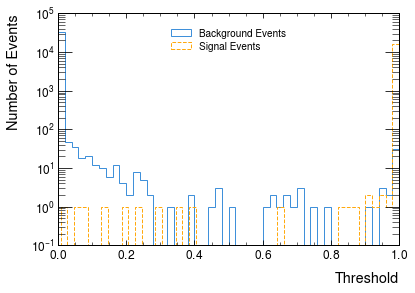

In [35]:
plt.hist(decisions_nn_full[y_test == 0], histtype="step", bins=50, label="Background Events")  # plot background
plt.hist(decisions_nn_full[y_test == 1], histtype="step",bins=50,linestyle="dashed",label="Signal Events",)  # plot signal
plt.xlabel("Threshold")  # x-axis label
plt.ylabel("Number of Events")  # y-axis label
plt.semilogy()  # make the y-axis semi-log
plt.legend()  # draw the legend

In [36]:
fpr_nn_full, tpr_nn_full, thresholds_nn_full = roc_curve(y_test, decisions_nn_full)

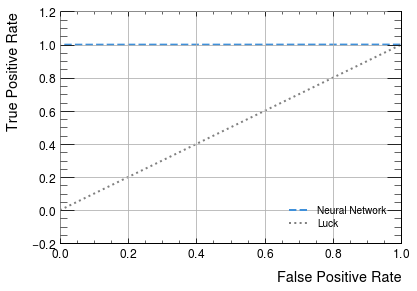

In [37]:
plt.plot(fpr_nn_full, tpr_nn_full, linestyle="dashed", label="Neural Network")  # plot neural network ROC
plt.plot([0, 1], [0, 1], linestyle="dotted", color="grey", label="Luck")  # plot diagonal line to indicate luck
plt.xlabel("False Positive Rate")  # x-axis label
plt.ylabel("True Positive Rate")  # y-axis label
plt.grid()  # add a grid to the plot
plt.legend()

In [38]:
def AMS(TPR,FPR,b_r):
    AMS = np.sqrt(2*(TPR+FPR+b_r)*np.log(1+TPR/(FPR+b_r))-TPR)
    return AMS

In [39]:
b_reg = 0.001
ams_nn_full = AMS(tpr_nn_full,fpr_nn_full,b_reg)

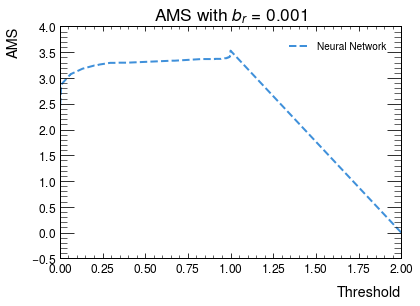

In [40]:
plt.plot(thresholds_nn_full, ams_nn_full, linestyle="dashed", label="Neural Network")  # plot neural network AMS
plt.xlabel("Threshold")  # x-axis label
plt.ylabel("AMS")  # y-axis label
plt.title(f"AMS with $b_r$ = {b_reg}")  # add plot title
plt.legend()
plt.show()

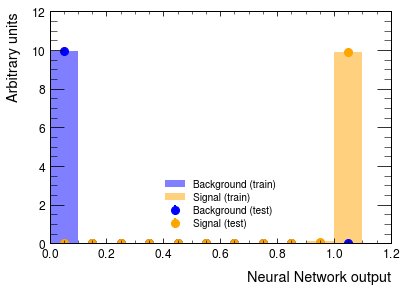

In [41]:
def compare_train_test(clf, X_train, y_train, X_test, y_test, xlabel):
    decisions = [] # list to hold decisions of classifier
    for X,y in ((X_train, y_train), (X_test, y_test)): # train and test
        if hasattr(clf, "predict_proba"): # if predict_proba function exists
            d1 = clf.predict_proba(X[y<0.5])[:, 1] # background
            d2 = clf.predict_proba(X[y>0.5])[:, 1] # signal
        else: # predict_proba function doesn't exist
            X_tensor = torch.as_tensor(X, dtype=torch.float) # make tensor from X_test_scaled
            y_tensor = torch.as_tensor(y, dtype=torch.long) # make tensor from y_test
            X_var, y_var = Variable(X_tensor), Variable(y_tensor) # make variables from tensors
            d1 = clf(X_var[y_var<0.5])[1][:, 1].cpu().detach().numpy() # background
            d2 = clf(X_var[y_var>0.5])[1][:, 1].cpu().detach().numpy() # signal
        decisions += [d1, d2] # add to list of classifier decision
    
    highest_decision = max(np.max(d) for d in decisions) # get maximum score
    bin_edges = [] # list to hold bin edges
    bin_edge = -0.1 # start counter for bin_edges
    while bin_edge < highest_decision: # up to highest score
        bin_edge += 0.1 # increment
        bin_edges.append(bin_edge)
    
    plt.hist(decisions[0], # background in train set
             bins=bin_edges, # lower and upper range of the bins
             density=True, # area under the histogram will sum to 1
             histtype='stepfilled', # lineplot that's filled
             color='blue', label='Background (train)', # Background (train)
            alpha=0.5 ) # half transparency
    plt.hist(decisions[1], # background in train set
             bins=bin_edges, # lower and upper range of the bins
             density=True, # area under the histogram will sum to 1
             histtype='stepfilled', # lineplot that's filled
             color='orange', label='Signal (train)', # Signal (train)
            alpha=0.5 ) # half transparency

    hist_background, bin_edges = np.histogram(decisions[2], # background test
                                              bins=bin_edges, # number of bins in function definition
                                              density=True ) # area under the histogram will sum to 1
    
    scale = len(decisions[2]) / sum(hist_background) # between raw and normalised
    err_background = np.sqrt(hist_background * scale) / scale # error on test background

    width = 0.1 # histogram bin width
    center = (bin_edges[:-1] + bin_edges[1:]) / 2 # bin centres
    
    plt.errorbar(x=center, y=hist_background, yerr=err_background, fmt='o', # circles
                 c='blue', label='Background (test)' ) # Background (test)
    
    hist_signal, bin_edges = np.histogram(decisions[3], # siganl test
                                          bins=bin_edges, # number of bins in function definition
                                          density=True ) # area under the histogram will sum to 1
    scale = len(decisions[3]) / sum(hist_signal) # between raw and normalised
    err_signal = np.sqrt(hist_signal * scale) / scale # error on test background
    
    plt.errorbar(x=center, y=hist_signal, yerr=err_signal, fmt='o', # circles
                 c='orange', label='Signal (test)' ) # Signal (test)
    
    plt.xlabel(xlabel) # write x-axis label
    plt.ylabel("Arbitrary units") # write y-axis label
    plt.legend() # add legend
compare_train_test(NN_clf_full, X_train_scaled, y_train, X_test_scaled, y_test, "Neural Network output")

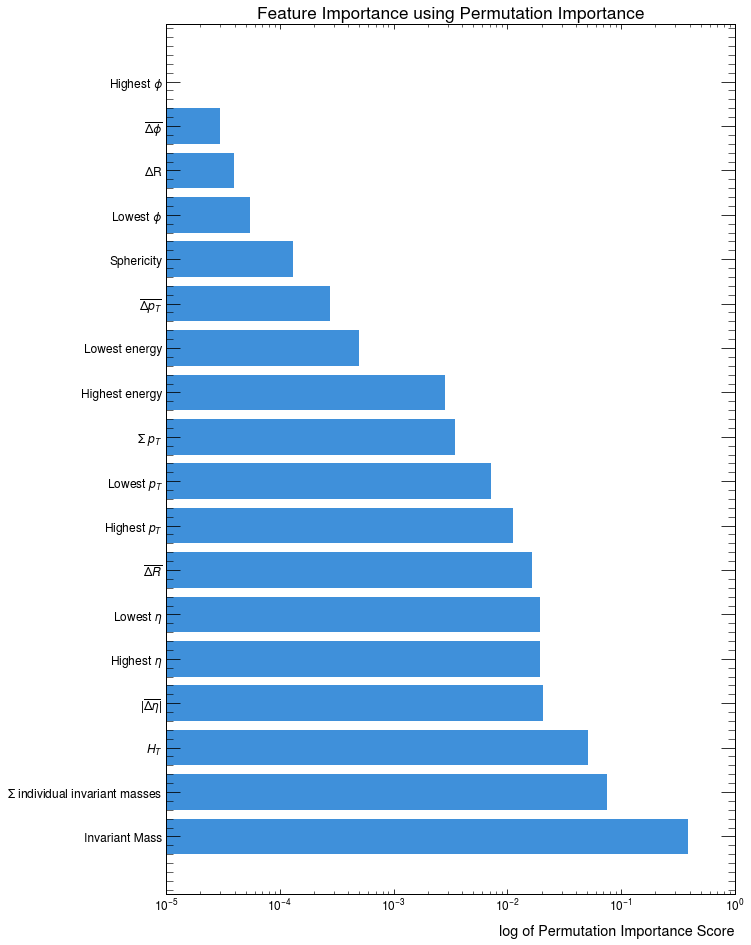

In [42]:
from sklearn.inspection import permutation_importance
# Calculate permutation importance
results = permutation_importance(NN_clf_full, X_test_tensor, y_test_tensor, n_repeats=30, random_state=42)
feature_names = feature_names_reduced
# Get the importance scores
importance_scores = results.importances_mean

# Rank the features based on importance
feature_importance = sorted(zip(importance_scores), reverse=True)

sorted_indices = np.argsort(importance_scores)[::-1]

# Sort the importance scores and feature names
sorted_importance_scores = importance_scores[sorted_indices]
sorted_feature_names = np.array(feature_names)[sorted_indices]

# Plotting
plt.figure(figsize=(10, 15))
plt.barh(sorted_feature_names, sorted_importance_scores, align='center')
plt.xlabel('log of Permutation Importance Score')
plt.xscale('log')
plt.title('Feature Importance using Permutation Importance')
plt.show()

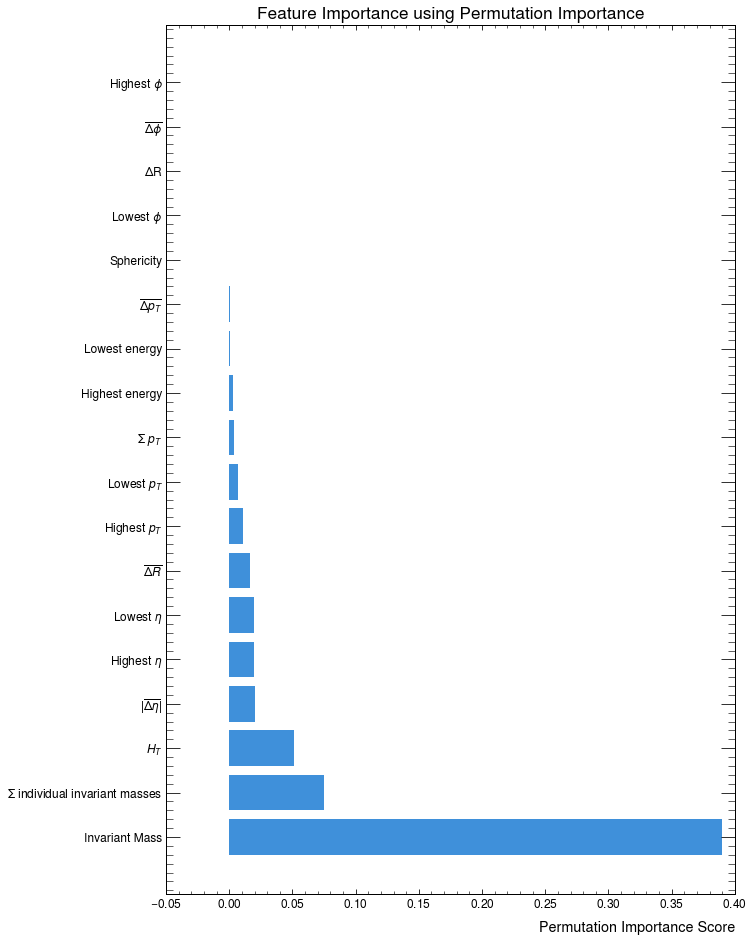

In [43]:
plt.figure(figsize=(10, 15))
plt.barh(sorted_feature_names, sorted_importance_scores, align='center')
plt.xlabel('Permutation Importance Score')
plt.title('Feature Importance using Permutation Importance')
plt.show()

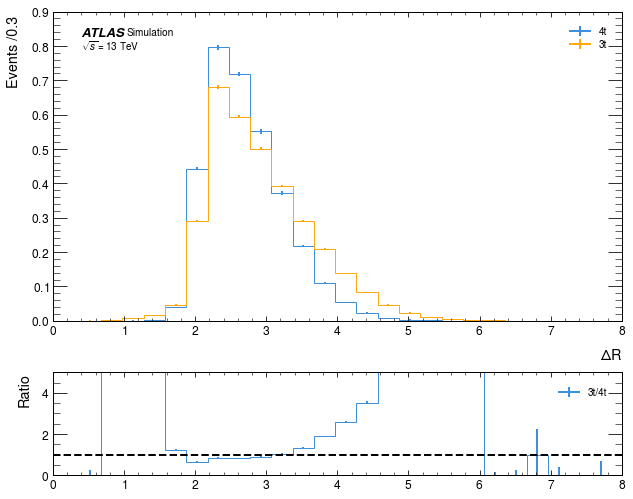

In [ ]:
fig, ax = plt.subplots(2,1,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
histogram([deltaR_4t,deltaR_3t], 25, ['4t','3t'], ax[0], ratio=True, ratio_axes=ax[1], density=True, x_units='')
ax[0].set_xlabel(r'$\Delta$R')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

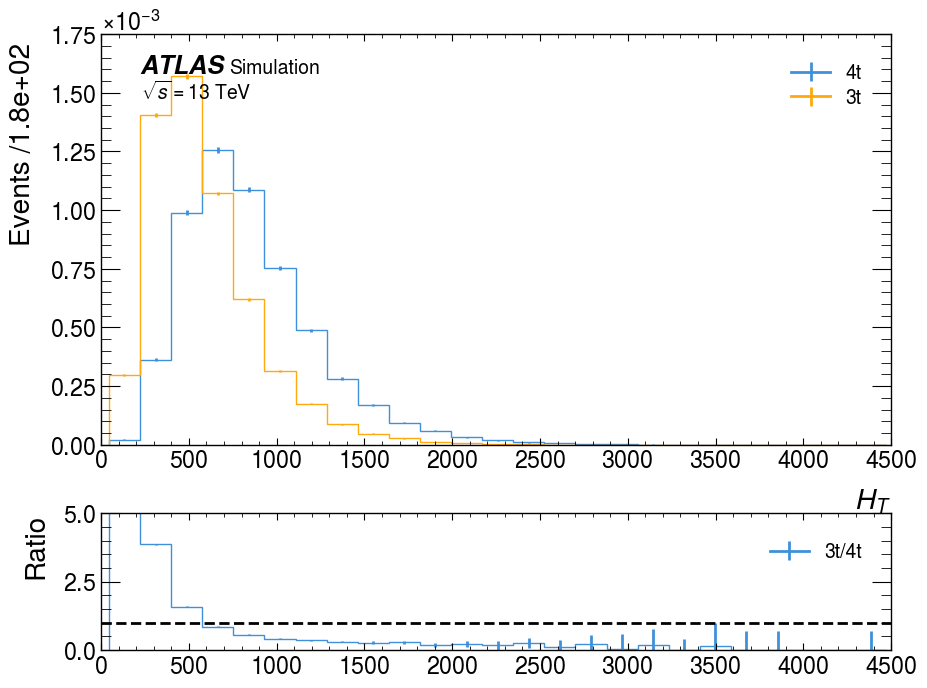

In [ ]:
fig, ax = plt.subplots(2,1,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
histogram([tops_4t_H_t,tops_3t_H_t], 25, ['4t','3t'], ax[0], ratio=True, ratio_axes=ax[1], density=True, x_units='')
ax[0].set_xlabel(r'$H_T$')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

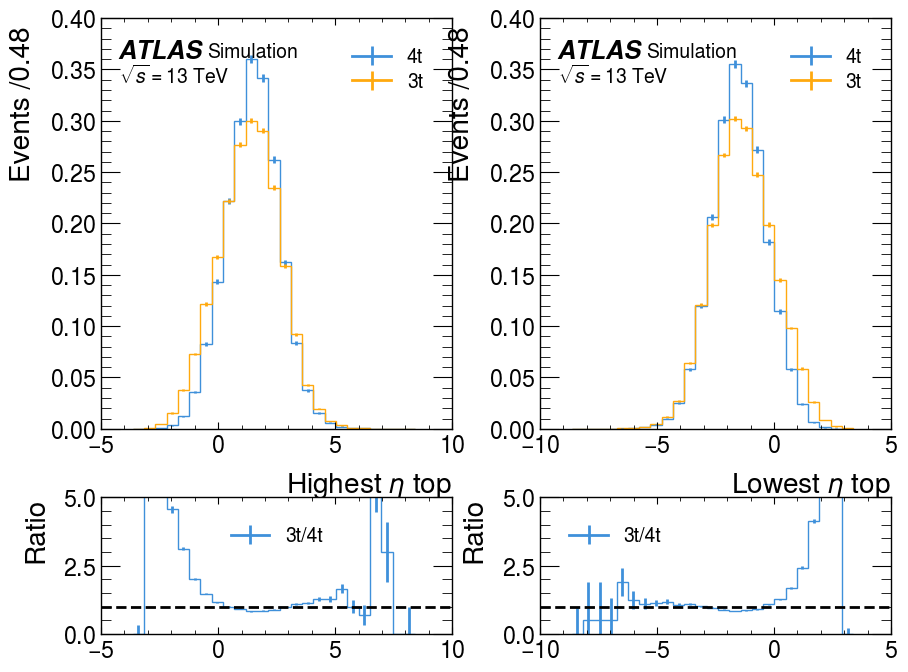

In [ ]:
fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
histogram([lowest_eta_4t.eta,lowest_eta_3t.eta,], 25, ['4t','3t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, x_units='')
histogram([highest_eta_4t.eta,highest_eta_3t.eta,], 25, ['4t','3t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, x_units='')
ax[0,0].set_xlabel(r'Highest $\eta$ top')
ax[0,1].set_xlabel(r'Lowest $\eta$ top')
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()